# Titanic - Machine Learning from Disaster
### How to break 80% accuracy

__Here is what kaggle tells us about the data__

<table>
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>

In [1]:
import re

import pandas as pd

In [2]:
# read in data
df = pd.read_csv('data/train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Anything that's not an int or float will need to be processed in some way to be used in an ML Algorithm
### Age has missing values, will need to fill them in

In [4]:
# here is a function to convert the raw text of the cabin column into the cabin class, if no class is listed, give it the value X
def cabin_mapping(x):
    if pd.isna(x):
        return 'X'
    cabin_class = re.findall(r'[A-Z]', x)[0]
    return cabin_class
# apply the function to the cabin column
df['cabin_class'] = df.Cabin.apply(cabin_mapping)

In [5]:
df.iloc[27]

PassengerId                                28
Survived                                    0
Pclass                                      1
Name           Fortune, Mr. Charles Alexander
Sex                                      male
Age                                        19
SibSp                                       3
Parch                                       2
Ticket                                  19950
Fare                                      263
Cabin                             C23 C25 C27
Embarked                                    S
cabin_class                                 C
Name: 27, dtype: object

In [6]:
# sometimes a passenger has more than one entry for cabin
# define a function to count how many rooms a passenger has, apply to the cabin column
def num_rooms(x):
    if pd.isna(x):
        return 0
    num_rooms = len(x.split(' '))
    return num_rooms
df['num_rooms'] = df.Cabin.apply(num_rooms)

In [7]:
# combine the sibling count column and the parent/child count column to create a family_size feature
df['fam_size'] = df.SibSp + df.Parch

In [8]:
# sometimes a passenger has a nicname, indicated by a name surrounded by quotation marks, let's use that as a feature
df.iloc[22]

PassengerId                             23
Survived                                 1
Pclass                                   3
Name           McGowan, Miss. Anna "Annie"
Sex                                 female
Age                                     15
SibSp                                    0
Parch                                    0
Ticket                              330923
Fare                                8.0292
Cabin                                  NaN
Embarked                                 Q
cabin_class                              X
num_rooms                                0
fam_size                                 0
Name: 22, dtype: object

In [9]:
df['nicnamed'] = df.Name.apply(lambda x: 1 if '"' in x else 0)

In [10]:
# kaggle tells us: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
# use estimated age a feature
df['est_age'] = df.Age.apply(lambda x: 0 if x.is_integer() else 1)

In [11]:
# fix the rows without age
df.Age = df.Age.fillna(df.Age.mean())

In [12]:
# lets see how Molly Brown is looking
df.iloc[194]

PassengerId                                          195
Survived                                               1
Pclass                                                 1
Name           Brown, Mrs. James Joseph (Margaret Tobin)
Sex                                               female
Age                                                   44
SibSp                                                  0
Parch                                                  0
Ticket                                          PC 17610
Fare                                             27.7208
Cabin                                                 B4
Embarked                                               C
cabin_class                                            B
num_rooms                                              1
fam_size                                               0
nicnamed                                               0
est_age                                                0
Name: 194, dtype: object

In [13]:
# encode the categorical variables:

# df = pd.get_dummies(df, columns=['Embarked', 'Sex', 'cabin_class', 'Pclass']) <- a little quicker

df = df.join(pd.get_dummies(df.Sex, drop_first=True))

df = df.join(
    pd.get_dummies(
        df.Embarked, drop_first=True
    ).add_prefix('embark_')
)

df = df.join(
    pd.get_dummies(
        df.cabin_class, drop_first=True
    ).add_prefix('cabin_')
)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  cabin_class  891 non-null    object 
 13  num_rooms    891 non-null    int64  
 14  fam_size     891 non-null    int64  
 15  nicnamed     891 non-null    int64  
 16  est_age      891 non-null    int64  
 17  male         891 non-null    uint8  
 18  embark_Q     891 non-null    uint8  
 19  embark_S

In [15]:
use_feats = [
#     'PassengerId',
#     'Survived',
    'Pclass',
#     'Name',
#     'Sex',
    'Age',
#     'SibSp',
#     'Parch',
#     'Ticket',
    'Fare',
#     'Cabin', 
#     'Embarked', 
#     'cabin_class',
    'num_rooms', 
    'fam_size', 
    'nicnamed', 
    'est_age', 
    'embark_Q',
    'embark_S', 
    'male', 
    'cabin_B', 
    'cabin_C', 
    'cabin_D', 
    'cabin_E',
    'cabin_F', 
    'cabin_G', 
#     'cabin_T', # there are no training examples in cabin T
    'cabin_X'
]

In [16]:
y = df.Survived.astype(int).values
x_df = df.loc[:,use_feats]

In [17]:
# check which of these are correlated and remove highly correlated features
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
def plot_corr(df):
    fig, ax = plt.subplots(figsize=(15,15))

    feature_correlation = df.corr()
    sns.heatmap(
        feature_correlation,
        xticklabels=feature_correlation.columns,
        yticklabels=feature_correlation.columns,
        annot=True,
        ax=ax
    )

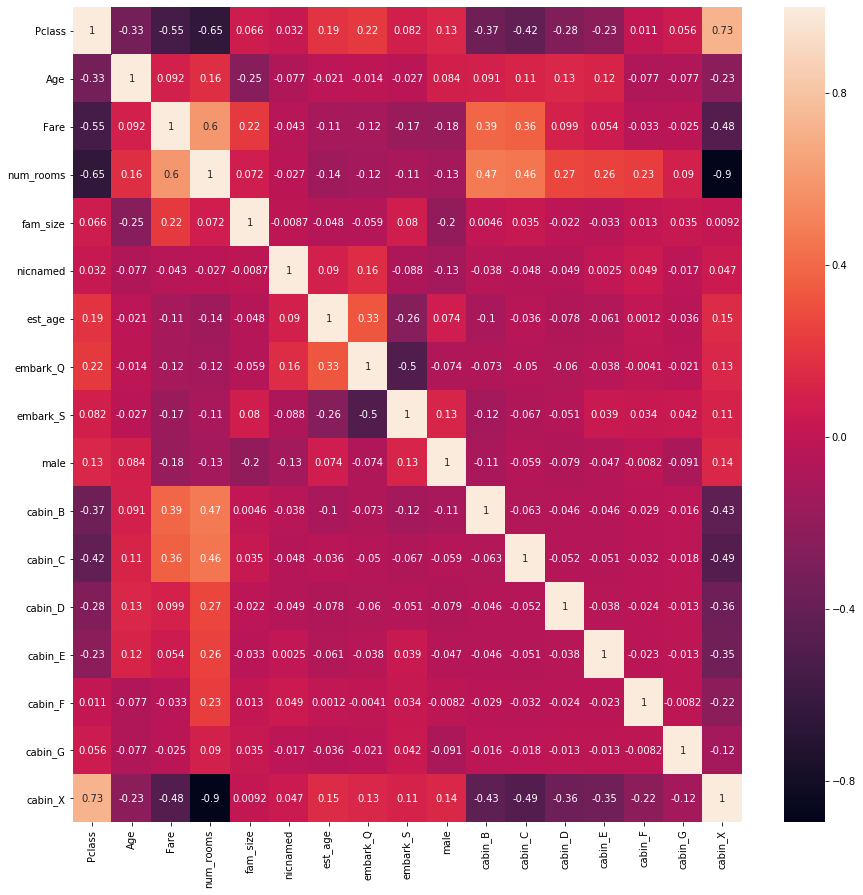

In [19]:
plot_corr(x_df)

In [20]:
# num rooms and cabin_X have a strong correlation
# it makes sense sense num_rooms (which was derived from the cabin column) would be zero when the value in cabin was nan.
df['num_rooms_or_x'] = df.num_rooms + df.cabin_X

In [21]:
use_feats = [
#     'PassengerId',
#     'Survived',
    'Pclass',
#     'Name',
#     'Sex',
    'Age',
#     'SibSp',
#     'Parch',
#     'Ticket',
    'Fare',
#     'Cabin', 
#     'Embarked', 
#     'cabin_class',
#     'num_rooms', 
    'fam_size', 
    'nicnamed', 
    'est_age',  
    'embark_Q',
    'embark_S', 
    'male', 
    'cabin_B', 
    'cabin_C', 
    'cabin_D', 
    'cabin_E',
    'cabin_F', 
    'cabin_G', 
#     'cabin_T', 
#     'cabin_X',
    'num_rooms_or_x'
]

In [22]:
x_df = df.loc[:,use_feats]

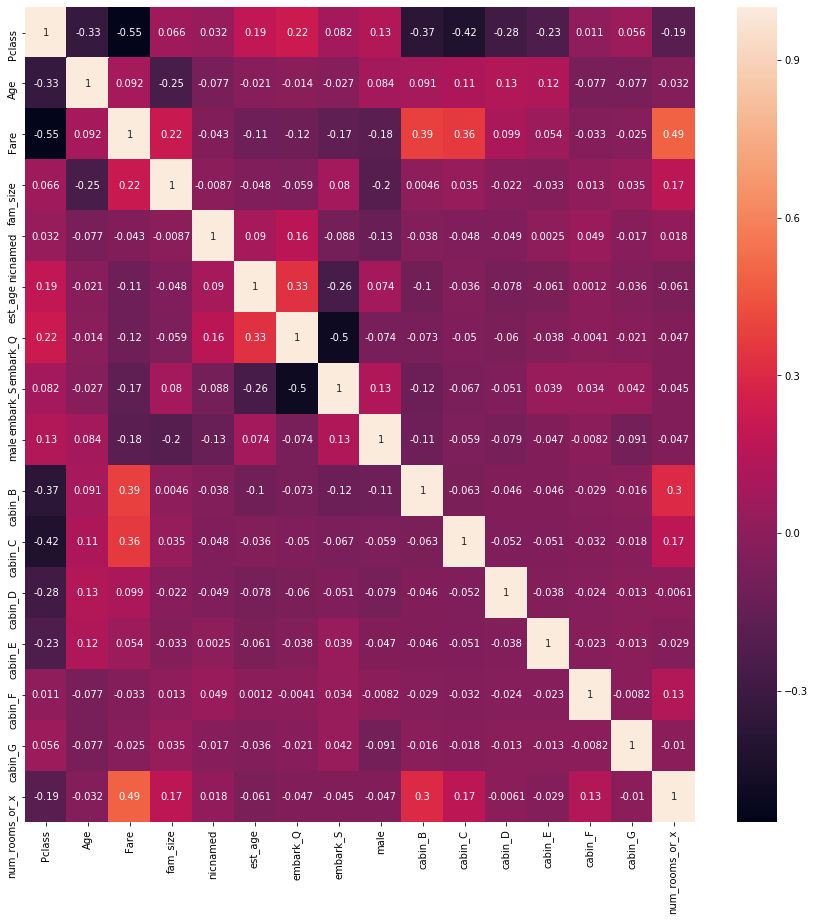

In [23]:
plot_corr(x_df)

In [35]:
x_df.iloc[75:85]

,Pclass,Age,Fare,fam_size,nicnamed,est_age,embark_Q,embark_S,male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,num_rooms_or_x
75,3,25.000000,7.6500,0,0,0,0,1,1,0,0,0,0,1,0,2
76,3,29.699118,7.8958,0,0,1,0,1,1,0,0,0,0,0,0,1
77,3,29.699118,8.0500,0,0,1,0,1,1,0,0,0,0,0,0,1
78,2,0.830000,29.0000,2,0,1,0,1,1,0,0,0,0,0,0,1
79,3,30.000000,12.4750,0,0,0,0,1,0,0,0,0,0,0,0,1
80,3,22.000000,9.0000,0,0,0,0,1,1,0,0,0,0,0,0,1
81,3,29.000000,9.5000,0,0,0,0,1,1,0,0,0,0,0,0,1
82,3,29.699118,7.7875,0,0,1,1,0,0,0,0,0,0,0,0,1
83,1,28.000000,47.1000,0,0,0,0,1,1,0,0,0,0,0,0,1
84,2,17.000000,10.5000,0,0,0,0,1,0,0,0,0,0,0,0,1


### no feature pair has a correlation coefficient higher than .55
### continue with training models

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test =\
train_test_split(x_df, y, random_state=0)

In [38]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [39]:
dt_preds = dt.predict(X_test)

In [40]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
rf_preds = rf.predict(X_test)

In [42]:
dt_acc = accuracy_score(y_test, dt_preds)
rf_acc = accuracy_score(y_test, rf_preds)
print(f"Out of Box Decision Tree achieved {round(dt_acc*100, 2)}% accuracy")
print(f"Out of Box Random Forest achieved {round(rf_acc*100, 2)}% accuracy")

Out of Box Decision Tree achieved 81.17% accuracy
Out of Box Random Forest achieved 82.51% accuracy


In [43]:
for n_est in [4, 12, 18, 36, 54, 75, 100, 125, 200]:
    rf = RandomForestClassifier(n_est)
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    rf_acc = accuracy_score(y_test, rf_preds)
    print(f"Random Forest (n_esitmators={n_est}) achieved {round(rf_acc*100, 2)}% accuracy")

Random Forest (n_esitmators=4) achieved 78.92% accuracy
Random Forest (n_esitmators=12) achieved 81.61% accuracy
Random Forest (n_esitmators=18) achieved 84.75% accuracy
Random Forest (n_esitmators=36) achieved 83.41% accuracy
Random Forest (n_esitmators=54) achieved 80.72% accuracy
Random Forest (n_esitmators=75) achieved 80.27% accuracy
Random Forest (n_esitmators=100) achieved 83.41% accuracy
Random Forest (n_esitmators=125) achieved 81.61% accuracy
Random Forest (n_esitmators=200) achieved 82.96% accuracy


In [44]:
rf_accs = []
for n_est in range(20, 1000, 10):
    rf = RandomForestClassifier(n_est)
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    rf_acc = accuracy_score(y_test, rf_preds)
    rf_accs.append(rf_acc)

In [45]:
plt.style.use('ggplot')

In [46]:
def plot_rf_acc(n_estimators, accuracies):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('accuracy')
    ax.plot(n_estimators, accuracies)

In [47]:
rf_accs[:3], list(range(20,1000,10))[:3]

([0.8071748878923767, 0.8295964125560538, 0.8295964125560538], [20, 30, 40])

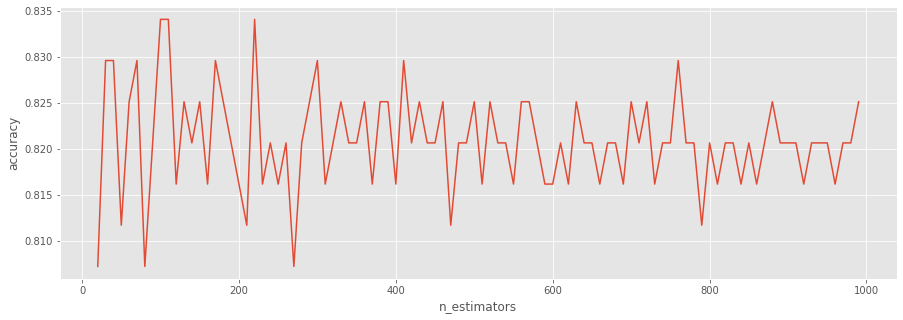

In [48]:
plot_rf_acc(range(20, 1000, 10), rf_accs)

In [49]:
rf_accs = []
for n_est in range(3, 30, 2):
    rf = RandomForestClassifier(n_est)
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    rf_acc = accuracy_score(y_test, rf_preds)
    rf_accs.append(rf_acc)

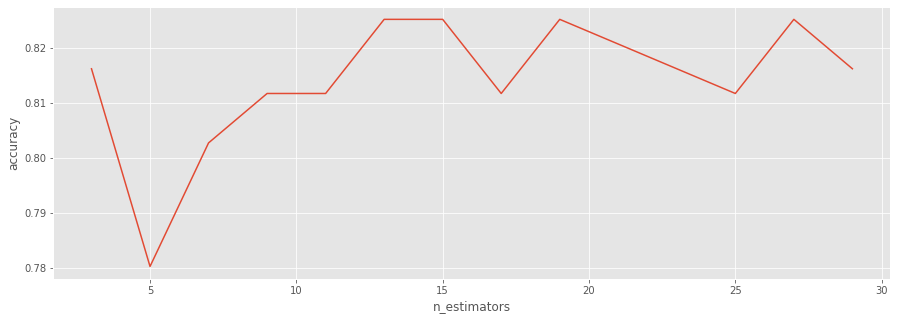

In [50]:
plot_rf_acc(range(3, 30, 2), rf_accs)

In [51]:
# best we got from rf
round(max(rf_accs) * 100, 2)

82.51

In [52]:
# try XGBoost
from xgboost import XGBClassifier

In [53]:
model = XGBClassifier(
    n_estimators=10, max_depth=15, tree_method='exact'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

[13:15:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [54]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.10%


In [55]:
accuracy - max(rf_accs)

0.0358744394618834

### XGBoost is more than 3% better than random forest!

In [56]:
# tune n_estimators
xg_accs = []
for n_est in range(5, 100, 5):
    model = XGBClassifier(
        n_estimators=n_est, max_depth=15, tree_method='exact'
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    xg_accs.append(accuracy)

[13:15:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

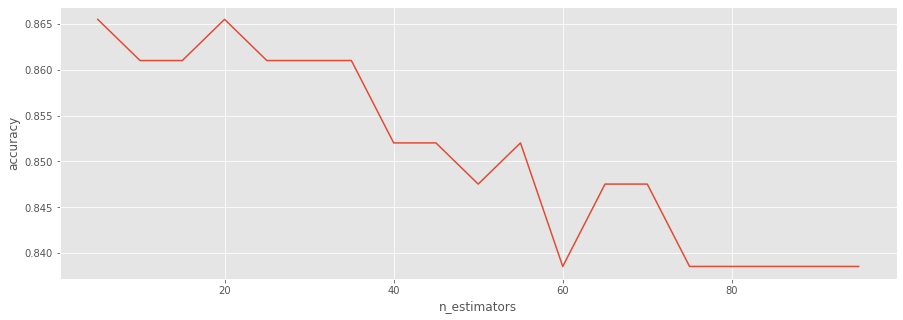

In [57]:
plot_rf_acc(range(5, 100, 5), xg_accs)

In [58]:
xg_accs = []
for n_est in range(2, 25):
    model = XGBClassifier(
        n_estimators=n_est, max_depth=15, tree_method='exact'
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    xg_accs.append(accuracy)

/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

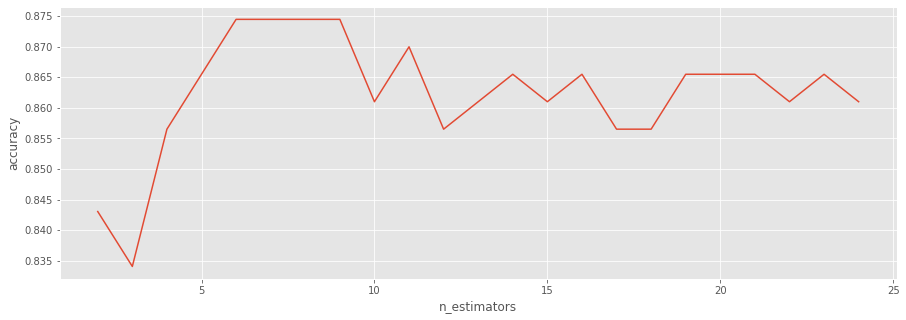

In [59]:
plot_rf_acc(range(2, 25), xg_accs)

In [60]:
# tune max_depth
xg_accs = []
for m_depth in range(5,25):
    model = XGBClassifier(
        n_estimators=10, max_depth=m_depth, tree_method='exact'
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    xg_accs.append(accuracy)

/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:15:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

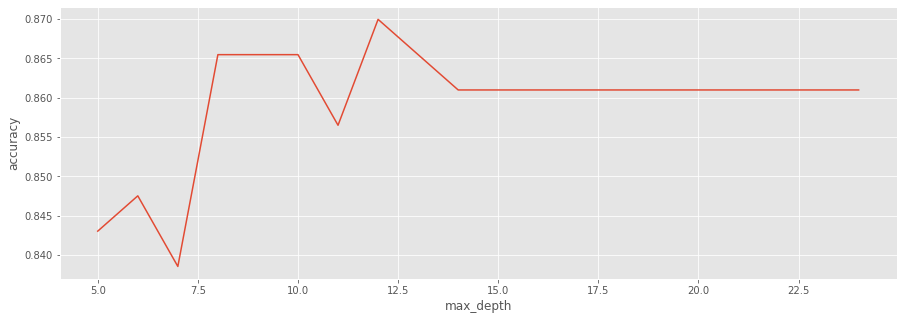

In [61]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.set_xlabel('max_depth')
ax.set_ylabel('accuracy')
ax.plot(range(5,25), xg_accs)

In [62]:
# for xgboost, I'll use n_estimators=10 and max_depth=15
# according to the graphs above, we should use n_estimators between 6-9
# it works out with the actual validation data that 10 estimators is better
# i know this thru trial and error, submitting the predictions of models
# trained on 6-9 estimators, and 10 estimators works out the best
# just minor differences in my validation set and the actual validation set
# k-fold validation would help this issue. for now, just use 10
model = XGBClassifier(
    n_estimators=10, max_depth=15, tree_method='exact'
)
model.fit(X_train, y_train)

[13:15:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [63]:
y_pred = model.predict(X_test)
xg_accuracy = accuracy_score(y_test, y_pred)
print(xg_accuracy)

0.8609865470852018


## Now use the decided on model to predict the test data

In [64]:
test_df = pd.read_csv('data/test.csv')

In [65]:
# pull in all transformations from above to make a function
def load_features(df):
    df['cabin_class'] = df.Cabin.apply(cabin_mapping)
    df['num_rooms'] = df.Cabin.apply(num_rooms)
    df['fam_size'] = df.SibSp + df.Parch
    df['nicnamed'] = df.Name.apply(lambda x: 1 if '"' in x else 0)
    df['est_age'] = df.Age.apply(lambda x: 0 if x.is_integer() else 1)
    
    df.Fare = df.Fare.fillna(df.Fare.mean()) # there is a null value in the test data
    df.Age = df.Age.fillna(df.Age.mean())
    
    df = df.join(pd.get_dummies(df.Sex, drop_first=True))

    df = df.join(
        pd.get_dummies(
            df.Embarked, drop_first=True
        ).add_prefix('embark_')
    )

    df = df.join(
        pd.get_dummies(
            df.cabin_class, drop_first=True
        ).add_prefix('cabin_')
    )

    df['num_rooms_or_x'] = df.num_rooms + df.cabin_X
    
    use_feats = [
        'Pclass',
        'Age',
        'Fare', 
        'fam_size', 
        'nicnamed', 
        'est_age',  
        'embark_Q',
        'embark_S', 
        'male', 
        'cabin_B', 
        'cabin_C', 
        'cabin_D', 
        'cabin_E',
        'cabin_F', 
        'cabin_G', 
        'num_rooms_or_x'
    ]
    x = df.loc[:,use_feats]
    passenger_ids = df.PassengerId
    
    return x, passenger_ids

In [66]:
x_validaion, passenger_ids = load_features(test_df)

In [67]:
valid_preds = model.predict(x_validaion)

In [68]:
# prepare a csv for kaggle submission
pd.DataFrame(
    zip(passenger_ids.values, valid_preds),
    columns=['PassengerId', 'Survived']
)\
.astype(int)\
.to_csv('data/titanic_predictions.csv', index=False)

## Submitting the above shows an accuracy on the validation data of 80.62%, which is the top 4% in the competition

![](img/kaggle_results.png)